WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2203-107-g17d84a784', 'mesh_dim': 3, 'order2d'…

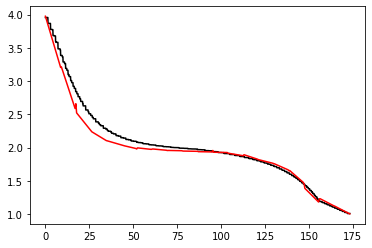

In [2]:
# Basic NGSolve things
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.meshes import MakeStructured3DMesh

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np

# physical discretization setups
K0 = IfPos(z-10, 1e-6, 1e-5) # matrix permeability
epsK1 = 1e-3                 # fracture prmeability

order, s, n0 = 0, 2, 20 # poly order & scaling power & mesh size

# structured hex mesh of size n0 x n0 x n0 
mesh = MakeStructured3DMesh(hexes=True, nx=n0, ny=n0, nz=n0, 
                            mapping=lambda x,y,z:(100*x, 100*y,100*z))

def getPlane(p0, p1, p2):
    t1 = p0-p1 
    t2 = p2-p1
    nrm = np.cross(t1/np.linalg.norm(t1), t2/np.linalg.norm(t2))
    phi = (x-p0[0])*nrm[0]+(y-p0[1])*nrm[1]+(z-p0[2])*nrm[2]
    return phi

# use one level set to reprent planer fracture
# the plane parametrization
phi = getPlane(np.array([100,0,20]), np.array([100,100,20]), np.array([0,0,80]))
lsetp1 = GridFunction(H1(mesh, order=1))
InterpolateToP1(phi, lsetp1)
ci = CutInfo(mesh, lsetp1)
Gamma_c  = { "levelset" : lsetp1, "domain_type" : IF}
# cells cut through fracture
Th_c = ci.GetElementsOfType(IF) 
# fracture normal direction
nf  = 1.0/grad(lsetp1).Norm() * grad(lsetp1)

# HDG FE-Spaces
V = VectorL2(mesh, order=order)
W = L2(mesh, order=order, all_dofs_together=False)
M = FacetFESpace(mesh, order=order)
fes = V*V*W*M

# Assign dirichlet DOFs for M
for el in fes.Elements(BND):
    if el.mat =="back": # x=0
        # find z-coordinate of barycenter
        z0 = (mesh[el.vertices[0]].point[2]+mesh[el.vertices[1]].point[2]+mesh[el.vertices[2]].point[2])/3
        if z0 > 90:
            for dof in el.dofs:
                fes.FreeDofs()[dof] = False
                fes.FreeDofs(True)[dof] = False
    if el.mat =="left": # x=0
        # find z-coordinate of barycenter
        z0 = (mesh[el.vertices[0]].point[2]+mesh[el.vertices[1]].point[2]+mesh[el.vertices[2]].point[2])/3
        if z0 < 10:
            for dof in el.dofs:
                fes.FreeDofs()[dof] = False
                fes.FreeDofs(True)[dof] = False

# test/trial functions
(u, ut,  p, phat), (v, vt, q, qhat) = fes.TnT()

# mesh size & normal direction
h = specialcf.mesh_size
n = specialcf.normal(3)

# set-up bilinear form
a = BilinearForm(fes, condense=True)
# volume contribution
a += 1/K0*(u-ut)*vt*dx
a += (1/K0*(ut*v)+grad(p)*v-u*grad(q))*dx
# boundary contribution
a += (u*n*(q-qhat)-(p-phat)*v*n)*dx(element_boundary=True)
# stabilization on regular cells
a += K0*(p-phat)*(q-qhat)*dx(element_boundary=True, 
                            definedonelements=~Th_c)
# stabilization on fractured cells
# characteristic length is 100
a += K0*(h/100)**(-s)*(p-phat)*(q-qhat)*dx(element_boundary=True, 
                            definedonelements=Th_c)

# surface integral on the 2D fractures
a += SymbolicBFI(levelset_domain = Gamma_c, 
                 form = - epsK1/K0**2 * (ut-ut*nf*nf) * (vt-vt*nf*nf),
                definedonelements=Th_c)

gfu = GridFunction(fes)
# impose dirichlet bc
gfu.components[3].Set(IfPos(z-50, 4, 1), definedon=mesh.Boundaries("left|back"))

# Local postprocessing
V2 = L2(mesh, order=order+1, all_dofs_together=False)
V2.FreeDofs()[:mesh.ne]=False
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
f2 += -gfu.components[1]/K0*grad(q2)*dx

with TaskManager():
    # matrix assembly
    a.Assemble()
    rhs = gfu.vec.CreateVector()
    rhs.data = - a.mat*gfu.vec
    # static condensation
    rhs.data += a.harmonic_extension_trans * rhs
    # global linear system solve for M: use sparse cholesky direct solver
    gfu.vec.data += a.mat.Inverse(fes.FreeDofs(True), inverse="sparsecholesky")*rhs
    # local solve
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * rhs
    
    # postprocessing
    a2.Assemble()
    f2.Assemble()
    # copy cell averge 
    ph.vec[:mesh.ne].data=gfu.components[2].vec[:mesh.ne]
    # (local) solve for slope
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs(), inverse="sparsecholesky")*f2.vec
    
    # use H1-conforming FEM for web-gui visualization
    ph_vis = GridFunction(H1(mesh, order=order+1))
    ph_vis.Set(ph)
    Draw(ph_vis, mesh)

    
# compare solution with reference data
data = "data/single/results/USTUTT/MPFA/dol_refinement_5.csv"
ref = np.loadtxt(data,comments='#',delimiter=',')

xx = np.linspace(0, 100, 401)
pp = np.array([ph(mesh(x, 100-x, 100-x)) for x in xx])
plt
plt.plot(ref.T[0], ref.T[1],'k')
plt.plot(xx*sqrt(3), pp, "r")